Generation and Exploration of the images 🔎
--------------------------------------

In this notebook we will generate the real/fake face's images in order to explore them. Let us add the scheduling bellow:

- Recuperate the images in lists from their directory. We must create a list for each of the type of images.
- Print the number of recuperated images.
- Visualize the images and compare them.
- Print the shapes of the images. If they have different shapes, identify a common shape for all the images and rescale them.
- Identify the augmentation methods to use on the images.
- Print the mean and the variance of the images and store them. 

Let us import bellow some libraries.

In [1]:
from torch.utils.tensorboard import SummaryWriter
from PIL.JpegImagePlugin import JpegImageFile
from torchvision import transforms
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn.utils as skl
from PIL import ImageDraw
from PIL import Image
from glob import glob
from typing import *
from math import *
import numpy as np
import pickle
import random
import torch
import os

c:\Users\Oumar Kane\AppData\Local\pypoetry\Cache\virtualenvs\pytorch1-HleOW5am-py3.10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let us initialize a directory where will stored the images and their characteristics.

In [2]:
fake_real_face = {}

### Recuperate the images

The images can be recuperated in lists inside the dictionary that we created. One list for the real images and another for the fake images. We stored the images in 'data/real_and_fake_face/' directory. Inside the directory the real images are classed in 'training_real' directory and the photoshed images are stored in 'training_fake' directory. 

In [3]:
path = 'data/real_and_fake_face/'

fake_path = "data/real_and_fake_face/training_fake/"

real_path = "data/real_and_fake_face/training_real/"

# recuperate real images
fake_real_face['real'] = [Image.open(image) for image in glob(os.path.join(real_path, "*"))]

# recuperate fake images
fake_real_face['fake'] = [Image.open(image) for image in glob(os.path.join(fake_path, "*"))]

### Number of recuperated images

Let us print bellow the number of images that we have recuperated and the percentages.

In [4]:
# recuperate the lengths
fake_real_face['len_real'] = len(fake_real_face['real'])
fake_real_face['len_fake'] = len(fake_real_face['fake'])
fake_real_face['n_images'] = fake_real_face['len_real'] + fake_real_face['len_fake']

print(f"Number of real images -> {fake_real_face['len_real']} ({round(fake_real_face['len_real'] * 100 / fake_real_face['n_images'])} %)")
print(f"Number of fake images -> {fake_real_face['len_fake']} ({round(fake_real_face['len_fake'] * 100 / fake_real_face['n_images'])} %)")
print(f"Number of images -> {fake_real_face['n_images']}")

Number of real images -> 1081 (53 %)
Number of fake images -> 960 (47 %)
Number of images -> 2041


Let us additionally print the difference between the lengths.

In [5]:
print(f"The difference of images is of {fake_real_face['len_real'] - fake_real_face['len_fake']}")

The difference of images is of 121


---------

**Conlusion**: We don't have a great difference between the percentages. But considering the difference between the lengths it will more accurate to recuperate the weights in order to use them later to avoid any Class Unbalance when making predictions. The weight of a class is given by the the number samples divided by the number of classes multiply by the number of occurrence of the considered class. See the following formula:

$$
weight(class) = \frac{n\_samples}{n\_classes \times n\_occurences}
$$


We must identify the id of each image. Let us take the real image class to be the positive class and the fake image class to be the negative one.

In [6]:
ids = {'real': 1, 'fake': 0}

fake_real_face['ids'] = ids # we will use it when pre-processing the images

We can use directly the class weight computation's method of `sklearn`.

In [7]:
%%writefile fake-face-detection/fake_face_detection/utils/compute_weights.py
import sklearn.utils as skl
from typing import *
import numpy as np

def compute_weights(samples: List[int]):
    """Compute the weights with the 'balanced' method

    Args:
        samples (List[int]): The samples: A list of integers

    Returns:
        numpy.ndarray: A array containing the weights
    """
    
    # get unique classes
    classes = np.unique(samples)
    
    # calculate the weights with the balanced method
    weights = skl.class_weight.compute_class_weight('balanced', classes=classes, y = samples)
    
    return weights


Overwriting fake-face-detection/fake_face_detection/utils/compute_weights.py


----------------

### Visualize a grid of images

This section imply to use tensorboard to visualize some images. We will use the directory <i style="color:green">fake_face_logs</i> for all next visualizations. Let us implement a function bellow which will make that process simple.

In [8]:
%%writefile fake-face-detection/fake_face_detection/utils/visualize_images.py
from torch.utils.tensorboard  import SummaryWriter
from PIL.JpegImagePlugin import JpegImageFile
import matplotlib.pyplot as plt
from typing import *
from math import *
import numpy as np
import random
import torch
import os

# use a style with no grid
plt.style.use("_mpl-gallery-nogrid")

def visualize_images(images_dict: Dict[str, Iterable[Union[JpegImageFile, torch.Tensor, np.ndarray]]], 
                     log_directory: str = "fake_face_logs",
                     n_images: int = 40,
                     figsize = (15, 15), 
                     seed: Union[int, None] = None):
    
    assert len(images_dict) > 0
    
    assert isinstance(images_dict, dict) 
    
    # add seed
    random.seed(seed)
    
    # verify if we must add a title for each image
    add_titles = len(images_dict) > 1
    
    images_ = []
    
    # modify the dictionary to obtain a tuple of images with their corresponding tags
    for key in images_dict:
        
        for image in images_dict[key]:
            
            images_.append((key, image))
        
    # we take the number of images in the list if n_images is larger
    if n_images > len(images_): n_images = len(images_)
    
    # choose random images
    images = random.choices(images_, k = n_images)
    
    if isinstance(images[0], JpegImageFile):
        
        images = [np.array(image[1]) for image in images if type(image[1]) in [JpegImageFile, torch.Tensor, np.ndarray]]
    
    # calculate the number of rows and columns
    n_rows = ceil(sqrt(n_images))
    
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_rows, figsize = figsize)
    
    # flat the axes
    axs = axs.flat
    
    # trace images
    for i in range(n_images):
        
        axs[i].imshow(images[i][1], interpolation = "nearest")
        
        if add_titles: axs[i].set_title(images[i][0])
        
        axs[i].axis('off')
    
    # add padding to the figure
    fig.tight_layout()
    
    # deleting no necessary plots
    [fig.delaxes(axs[i]) for i in range(n_images, n_rows * n_rows)]
    
    # add figure to tensorboard
    with SummaryWriter(os.path.join(log_directory, "images")) as writer:
        
        # identify the tag
        tag = "_".join(list(images_dict)) if add_titles else list(images_dict.keys())[0]
        
        writer.add_figure(tag = tag, figure = fig)
    


Overwriting fake-face-detection/fake_face_detection/utils/visualize_images.py


In [9]:
%run fake-face-detection/fake_face_detection/utils/visualize_images.py

Let us add some images in tensorboard.

In [10]:
# adding the real images
visualize_images({'fake': fake_real_face['fake'], 'real': fake_real_face['real']})

-------------

In [11]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [12]:
# Visualize logged images
# %tensorboard --logdir fake_face_logs

----------

### Investigate the shapes

In this section we want to verify if all the images have the same shape. Let us investigate it bellow.

In [13]:
fake_real_face['real'][0].size

(600, 600)

In [14]:
# first verify if all images have the same shape
images = []

# add real images
images.extend(fake_real_face['real'])

# add fake images
images.extend(fake_real_face['fake'])

# verify with numpy if all images have equal sizes
sizes = np.array([image.size for image in images], dtype=object)

sum(sizes == sizes[0]) == sizes.shape[0]

array([ True,  True])

We have the same sizes for all the images. Let us recuperate the common shape of the images.


In [15]:
fake_real_face['shape'] = tuple(sizes[0])

**Note**: It was only a verification to avoid any mistake at the next sections but we will resize the shape of the images when using them for the training. So the actual shapes of the image do not matter for the training.

### Augmentation methods to use

Let us define a function which display a image with pil.

In [16]:
%%writefile fake-face-detection/fake_face_detection/utils/display_pil.py
from PIL.JpegImagePlugin import JpegImageFile
from PIL import ImageDraw
from PIL import Image
from typing import *

def display(images: List[JpegImageFile], labels: List[str], w: int = 300, h: int = 200, left_color: str = "white", right_color: str = "white"):
    """Display a dual image

    Args:
        images (List[JpegImageFile]): A list containing two images
        labels (List[str]): The labels of the images
        w (int, optional): The width. Defaults to 300.
        h (int, optional): The height. Defaults to 200.
        left_color (str, optional): The color of left label. Defaults to "white".
        right_color (str, optional): The color of the right label. Defaults to "white".

    Returns:
        PIL.Image: A pillow image
    """
    
    # define a grid
    grid = Image.new('RGB', size=(w, h))
    
    # draw the grid
    draw = ImageDraw.Draw(grid, mode='RGB')
    
    # define the second box
    box = (w // 2,  0)
    
    # define the size of the images
    size = (w // 2, h)
    
    # add images to the grid
    grid.paste(images[0].resize(size))
    
    grid.paste(images[1].resize(size), box = box)
    
    # draw labels
    draw.text((0, 0), labels[0], fill=left_color)
    
    draw.text(box, labels[1], fill=right_color)
    
    return grid

Overwriting fake-face-detection/fake_face_detection/utils/display_pil.py


In [17]:
%run fake-face-detection/fake_face_detection/utils/display_pil.py

Since the number of images in our dataset is not very important we must add some noise on the images to perform better by making the model more robust to variations and not over-fit. The following augmentation methods can be added to the images:

- <i style = "color: orange">Random Horizontal Flip</i>: This method will not alter the original images since a face must be recognized at any orientation. The only parameter that will be required for that method is the probability of an image to be flipped. Let us do it on a random image in the data set to illustrate that method. 

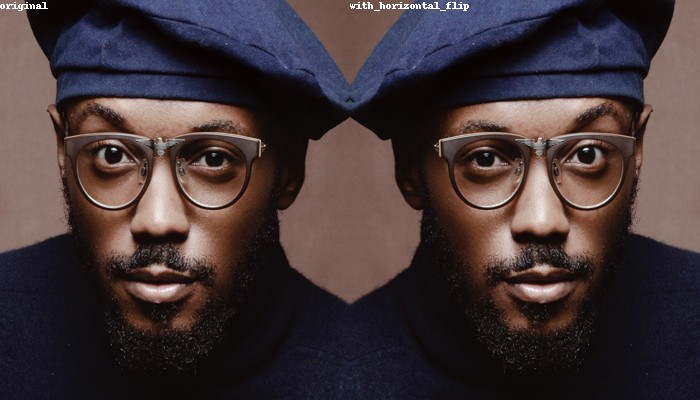

In [18]:
random.seed(0)

image = random.choice(fake_real_face['real'])

hf_image = transforms.RandomHorizontalFlip(p=1)(image)

display([image, hf_image], ['original', 'with_horizontal_flip'], w=700, h=400)

- <i style = "color: orange">Random Vertical Flip</i>: We will use it for the same reason that for the previous method. The only parameter that will be required for that method is the probability of an image to be flipped. 

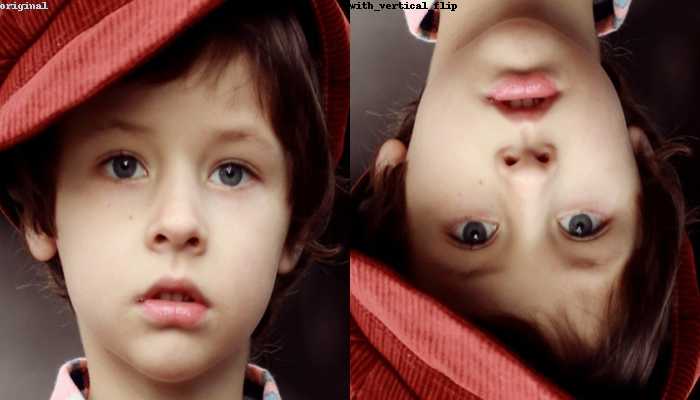

In [19]:
random.seed(10)

image = random.choice(fake_real_face['real'])

vf_image = transforms.RandomVerticalFlip(p=1)(image)

display([image, vf_image], ['original', 'with_vertical_flip'], w=700, h=400, left_color="lightblue", right_color="black")

- <i style = "color: orange">Random Gray Scale</i>: All images are in RGB but changing them to Grayscale will alterate the shape of the faces but we will remove the colors. It will train the model to focus more on the shape of the faces and not on the colors which can be sometimes give us rise to not identify fake images. In the case which the gray scale is more real that the original one that implies adding noise to the image like with the following example and to make the model not over-fit.

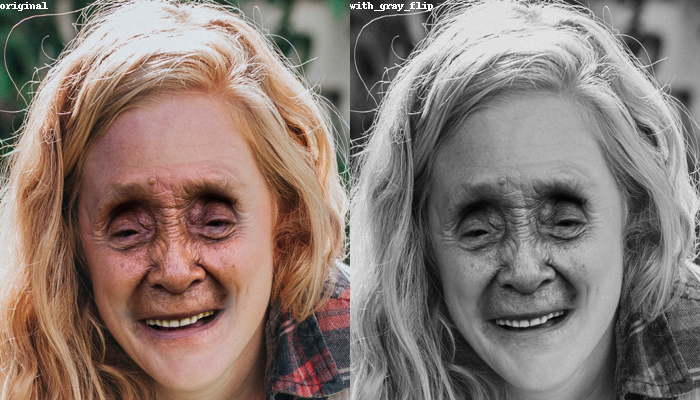

In [20]:
random.seed(100)

image = random.choice(fake_real_face['fake'])

gr_image = transforms.RandomGrayscale(p=1)(image)

display([image, gr_image], ['original', 'with_gray_flip'], w=700, h=400)

- <i style = "color: orange">Random Rotation</i>: Rotation make the image to seem instable and it can be sometimes the case when taking a photo. That will force the model to generalize to non seen images. This method take one argument which is the range of degrees of rotation from 0 to 360. Let us fix it to (0, 90). However, we will try to find if the rotation is necessary because it can add too noise to the image because we already have to use the random vertical flip and the horizontal flip as augmentation methods.

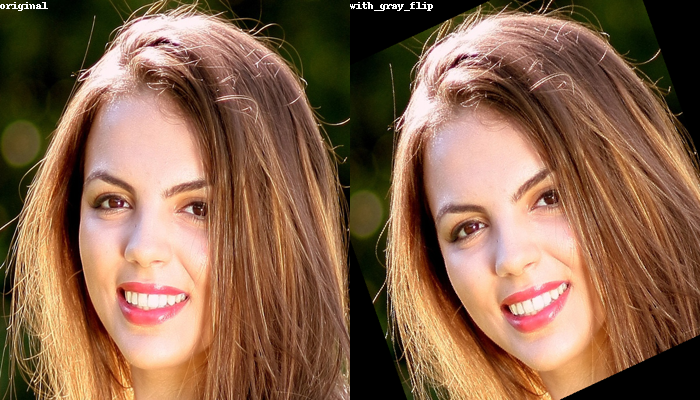

In [21]:
random.seed(1)

image = random.choice(fake_real_face['real'])

rot_image = transforms.RandomRotation(degrees=(0, 90))(image)

display([image, rot_image], ['original', 'with_gray_flip'], w=700, h=400)

### Mean and variance of the images

Let us recuperate the means and the variances of the images (on each color dimension) for the purpose of the study (for upcoming modeling on the images). For the preprocessing we will use another pre-defined transfer learning's means and variances.

Let us first, recuperate the images in a numpy array.

In [22]:
# recuperate in a numpy array (it can take some moment since we have 2041 images to concatenate and calculate their means and variances)
fake_real_face['images'] = images

np_images = np.stack([np.array(image) for image in fake_real_face['images']])

In [23]:
# let print the type of the image (can be int -> from 0 to 255 or float -> from 0 to 1)
np_images.dtype

dtype('uint8')

We have integer values. We must convert the values to float by dividing with 255. We will do it when calculating the means and variances. Let us visualize the distribution of the pixels of the mean of 200 samples taken from the dataset.

In [40]:
flat_images = [image.ravel() for image in np_images]

samples = np.stack(random.choices(np_images, k = 200)).mean(axis = (1, 2))

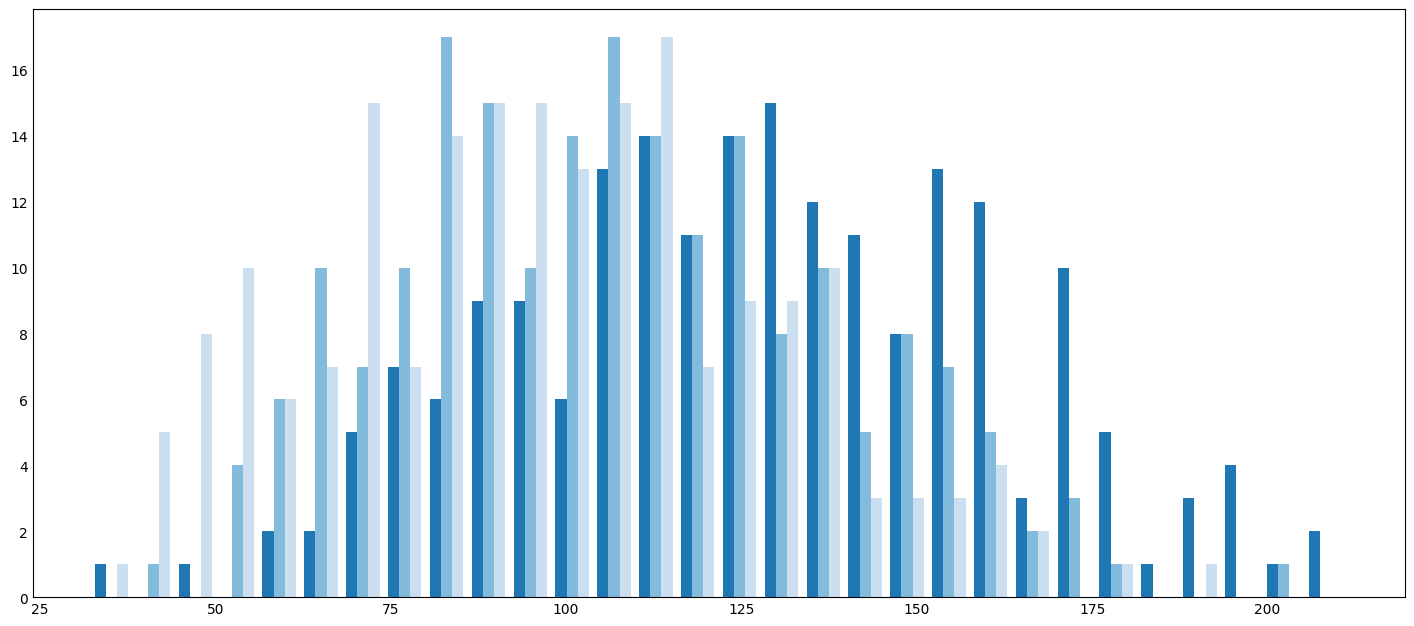

In [50]:
plt.figure(figsize=(14, 6))

plt.hist(samples, bins=30)

plt.show()

In the plot we can see the pixels seems to follows a normal distribution. It seems that the means is very close to the middle (0.5 of max pixel) of the distribution but it seems that it is not the case for the variance. See the next notebook for discussion on the true means and variances that must follow the pixels of the colors of the images. 

Let us compare a normal distribution of pixels following a means of 0.5 and standard deviation of 0.5 with that of our current images:

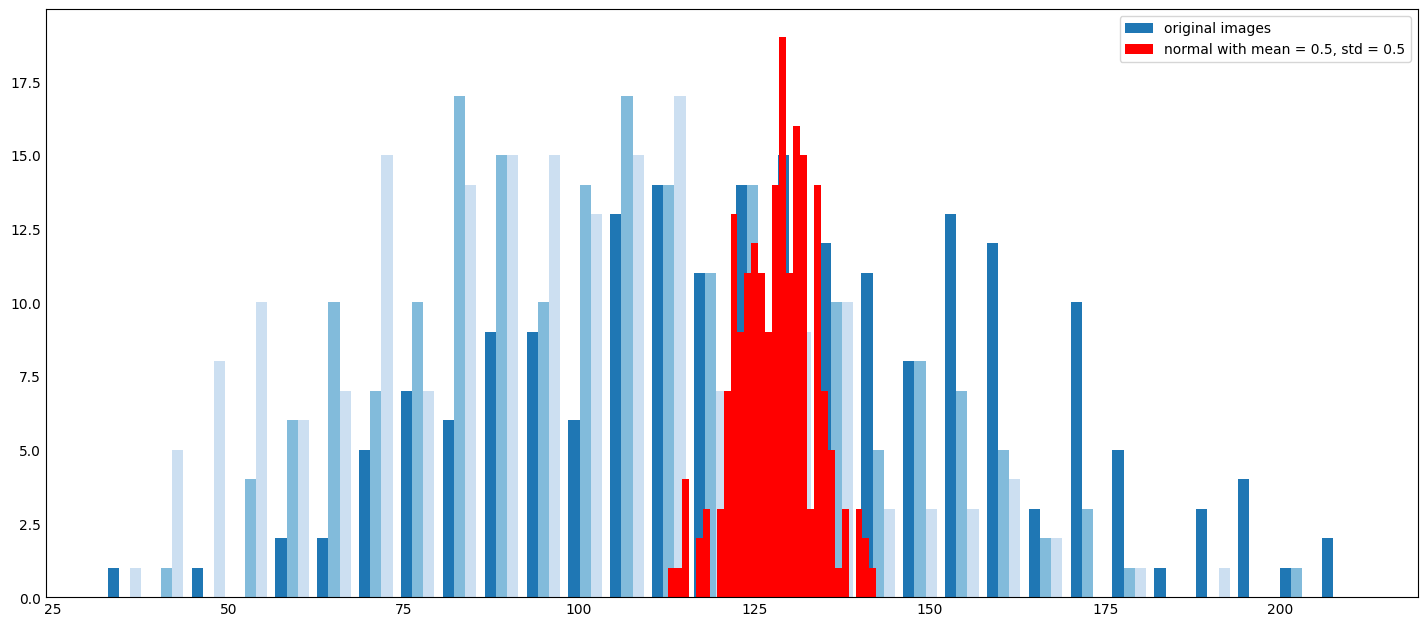

In [64]:
good_distribution = np.random.normal(0.5, 0.5, size = (200, 600)).mean(axis = 1)

plt.figure(figsize=(14, 6))

plt.hist(samples, bins=30, label="original images")

plt.hist(good_distribution * 255, bins=30, color='red', label="normal with mean = 0.5, std = 0.5")

plt.legend()

plt.show()

We can see they have almost the same means but not the same standard deviations.

To calculate the means and the variance of the images on color dimensions we must keep the color dimension and average values on the other dimensions. For numpy the color dimension is the third dimension so we will calculate the average on the dimensions number 0, 1 and 2. We will need to make the calculation by batches and average the result since we have a great number of images to process.

In [44]:
batch = 3 # batch size

means = np.array([0., 0., 0.]) # means

var = np.array([0., 0., 0.]) # variances

n_ops = 0 # number of operations

for i in range(0, np_images.shape[0], batch):
    
    array_ = np_images[i:i + batch] / 255
    
    means += np.mean(array_, axis = (0, 1, 2))

    var += np.var(array_, axis = (0, 1, 2))
    
    if i == 0: rescaled_imgs = array_
                          
    n_ops += 1
    
means /= n_ops

var /= n_ops

In [45]:
means, var

(array([0.51424026, 0.42879717, 0.38588453]),
 array([0.07777136, 0.06481383, 0.06337294]))

Let us add the rescaled images, the original images and the statistics into the dictionary of characteristics.

In [46]:
fake_real_face['means'] = means

fake_real_face['var'] = var

Notice that we will use the square root of the variance (standard deviation) for the normalization.

------------------

We will only need to save the characteristics so let us delete the original images from the dictionary.

In [68]:
del fake_real_face['fake']
del fake_real_face['real']
del fake_real_face['images']

In [69]:
with open("data/extractions/fake_real_dict.txt", "wb") as f:
    
    pickler = pickle.Pickler(f)
    
    pickler.dump(fake_real_face)

OSError: [Errno 22] Invalid argument: 'data/extractions/fake_real_dict.txt'

---------------